<a href="https://colab.research.google.com/github/Kryptera-K/TPR-Keltner-QQE-Shooting-Strategy/blob/main/TPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "TPR"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("TPR_clean.csv", index=False)
df

/tmp/ipython-input-1998345073.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-10-06,1.582725,1.674036,1.521851,1.653744,7776800
2000-10-09,1.471123,1.577653,1.471123,1.577653,2759200
2000-10-10,1.491413,1.542142,1.460976,1.460976,2257600
2000-10-11,1.440685,1.486341,1.430540,1.486341,3709600
2000-10-12,1.369666,1.420394,1.298646,1.420394,4552000
...,...,...,...,...,...
2025-10-23,114.900002,116.400002,114.169998,114.779999,2289400
2025-10-24,114.709999,116.029999,113.870003,114.940002,1465500
2025-10-27,114.970001,116.379997,112.660004,116.379997,2959700


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

BEAR_EMA_PERIOD = 13
BEAR_POWER_LEVEL = 0
BEAR_POWER_SHIFT = 5
KC_MULTIPLIER = 2
KC_PERIOD = 20
KC_SHIFT = 5
QQE_FACTOR = 4.236
QQE_LEVEL = 50
QQE_PERIOD = 14
QQE_SHIFT = 5
QQE_SMOOTH = 5

# -------------------------
# Indicator Functions
# -------------------------

def bears_power_lower_than(df, period = BEAR_EMA_PERIOD, level=BEAR_POWER_LEVEL):
    df = calculate_bears_power(df, period)
    return df['Bears_Power'] < level


def calculate_bears_power(df, period=BEAR_EMA_PERIOD):
    """Calculate Bears Power indicator and return updated DataFrame"""
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    df['Bears_Power'] = df['Low'] - df['EMA']
    return df


def kc_upper_band_rising(df, shift=KC_SHIFT):
    df = calculate_keltner_channel(df)
    return df['KC_Upper'] > df['KC_Upper'].shift(shift)


def calculate_keltner_channel(df, period=KC_PERIOD, multiplier=KC_MULTIPLIER):
    """
    Calculate Keltner Channel (Mid, Upper, Lower) and ATR.
    """
    df = df.copy()

    # Typical Price
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3

    # EMA of Typical Price
    df['KC_Mid'] = df['TP'].ewm(span=period, adjust=False).mean()

    # True Range and ATR
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(period).mean()

    # Upper and Lower Bands
    df['KC_Upper'] = df['KC_Mid'] + multiplier * df['ATR']
    df['KC_Lower'] = df['KC_Mid'] - multiplier * df['ATR']

    return df


def shooting_star(df):
    body = abs(df['Close'] - df['Open'])
    lower_shadow = df[['Open','Close']].min(axis=1) - df['Low']
    upper_shadow = df['High'] - df[['Open','Close']].max(axis=1)
    return (upper_shadow >= 2 * body) & (lower_shadow <= body)


def qqe_cross_below_value2(df):
    df = calculate_qqe(df)
    return (df['QQE_Value1'] < df['QQE_Value2']) & (df['QQE_Value1'].shift(1) >= df['QQE_Value2'].shift(1))


def calculate_qqe(df, rsi_period=QQE_PERIOD, smooth=QQE_SMOOTH, factor=QQE_FACTOR):
    """
    Calculate QQE lines (Value1 & Value2) based on RSI smoothing and ATR-like smoothing.
    """
    df = df.copy()

    # --- RSI ---
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))

    # --- Smoothed RSI ---
    rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')

    # --- RSI Delta & ATR-like smoothing ---
    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/smooth, adjust=False).mean()

    # --- QQE Calculation ---
    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]

    for i in range(1, len(df)):
        prev_trail = value2.iloc[i-1]
        prev_value1 = value1.iloc[i-1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * factor * atr

    df['QQE_Value1'] = value1
    df['QQE_Value2'] = value2

    return df



# -------------------------
# Entry conditions
# -------------------------

df["BearP_Lower_0"] = bears_power_lower_than(df)
df["KC_Upper_Band_Rising"] = kc_upper_band_rising(df)

# -------------------------
# Exit conditions
# -------------------------

df["Shooting_Star"] = shooting_star(df)
df["QQE_Value1_CrossBelow_Value2"] = qqe_cross_below_value2(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'BearP_Lower_0',
    'KC_Upper_Band_Rising',
]
exit_conditions = [
    'Shooting_Star',
    'QQE_Value1_CrossBelow_Value2',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

/tmp/ipython-input-1368398773.py:91: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')


Start                                2000-10-06 00:00:00
End                                  2025-10-29 00:00:00
Period                                6303 days 00:00:00
Start Value                                     100000.0
End Value                                 9661205.667057
Total Return [%]                             9561.205667
Benchmark Return [%]                         6713.024278
Max Gross Exposure [%]                             100.0
Total Fees Paid                            313840.276817
Max Drawdown [%]                               76.466263
Max Drawdown Duration                 2730 days 00:00:00
Total Trades                                          64
Total Closed Trades                                   63
Total Open Trades                                      1
Open Trade PnL                             389759.241747
Win Rate [%]                                   58.730159
Best Trade [%]                                122.405222
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-10-06 00:00:00
End                           2025-10-29 00:00:00
Period                         6303 days 00:00:00
Start Value                              100000.0
End Value                           6813024.27793
Total Return [%]                      6713.024278
Benchmark Return [%]                  6713.024278
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                         82.32109
Max Drawdown Duration          3179 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      6713024.27793
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-4219313394.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4219313394.py:58: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



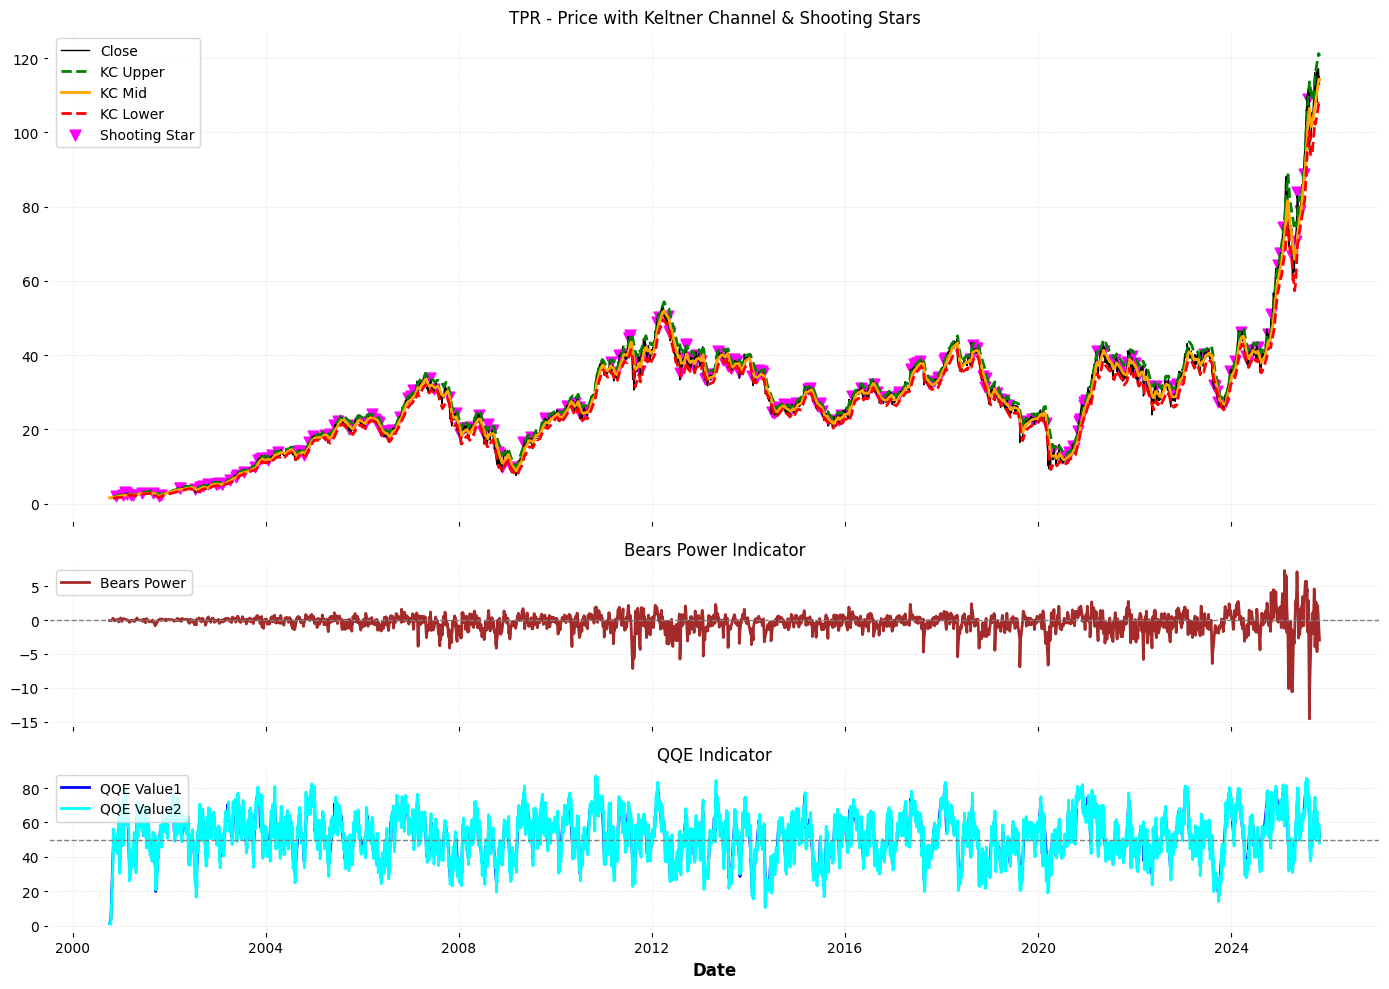

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------
symbol = "TPR"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.dropna(inplace=True)

# -------------------------
# Parameters
# -------------------------
BEAR_EMA_PERIOD = 13
KC_PERIOD = 20
KC_MULTIPLIER = 2
QQE_PERIOD = 14
QQE_SMOOTH = 5
QQE_FACTOR = 4.236

# -------------------------
# Indicator Functions
# -------------------------
def calculate_bears_power(df, period=BEAR_EMA_PERIOD):
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    df['Bears_Power'] = df['Low'] - df['EMA']
    return df

def calculate_keltner_channel(df, period=KC_PERIOD, multiplier=KC_MULTIPLIER):
    df = df.copy()
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['KC_Mid'] = df['TP'].ewm(span=period, adjust=False).mean()

    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(period).mean()

    df['KC_Upper'] = df['KC_Mid'] + multiplier * df['ATR']
    df['KC_Lower'] = df['KC_Mid'] - multiplier * df['ATR']
    return df

def calculate_qqe(df, rsi_period=QQE_PERIOD, smooth=QQE_SMOOTH, factor=QQE_FACTOR):
    df = df.copy()
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))
    rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')

    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/smooth, adjust=False).mean()

    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]
    for i in range(1, len(df)):
        prev_trail = value2.iloc[i-1]
        prev_value1 = value1.iloc[i-1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * factor * atr

    df['QQE_Value1'] = value1
    df['QQE_Value2'] = value2
    return df

def shooting_star(df):
    body = abs(df['Close'] - df['Open'])
    lower_shadow = df[['Open','Close']].min(axis=1) - df['Low']
    upper_shadow = df['High'] - df[['Open','Close']].max(axis=1)
    return (upper_shadow >= 2 * body) & (lower_shadow <= body)

# -------------------------
# Calculate Indicators
# -------------------------
df = calculate_bears_power(df)
df = calculate_keltner_channel(df)
df = calculate_qqe(df)
df['ShootingStar'] = shooting_star(df)

# -------------------------
# Plot in Separate Panels
# -------------------------
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})
plt.subplots_adjust(hspace=0.15)

# --- Panel 1: Price + Keltner + Shooting Star ---
axes[0].plot(df.index, df['Close'], label='Close', color='black', linewidth=1)
axes[0].plot(df.index, df['KC_Upper'], label='KC Upper', color='green', linestyle='--')
axes[0].plot(df.index, df['KC_Mid'], label='KC Mid', color='orange')
axes[0].plot(df.index, df['KC_Lower'], label='KC Lower', color='red', linestyle='--')

# Shooting star markers
axes[0].scatter(df[df['ShootingStar']].index, df[df['ShootingStar']]['High'],
                color='magenta', marker='v', s=60, label='Shooting Star')

axes[0].set_title(f"{symbol} - Price with Keltner Channel & Shooting Stars")
axes[0].legend(loc='upper left')
axes[0].grid(True, linestyle='--', alpha=0.3)

# --- Panel 2: Bears Power ---
axes[1].plot(df.index, df['Bears_Power'], label='Bears Power', color='brown')
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1].set_title("Bears Power Indicator")
axes[1].legend(loc='upper left')
axes[1].grid(True, linestyle='--', alpha=0.3)

# --- Panel 3: QQE Indicator ---
axes[2].plot(df.index, df['QQE_Value1'], label='QQE Value1', color='blue')
axes[2].plot(df.index, df['QQE_Value2'], label='QQE Value2', color='cyan')
axes[2].axhline(50, color='gray', linestyle='--', linewidth=1)
axes[2].set_title("QQE Indicator")
axes[2].legend(loc='upper left')
axes[2].grid(True, linestyle='--', alpha=0.3)

plt.xlabel("Date")
plt.tight_layout()
plt.show()
